# Train Networks

- Train SoftMax or Multi-BCE classifier for the EEG diagnosis classification
    - CAUEEG-Dementia benchmark: Classification of **Normal**, **MCI**, and **Dementia** symptoms
    - CAUEEG-Abnormal benchmark: Classification of **Normal** and **Abnormal** symptoms
- `Weights and Biases` sweep is used for hyperparameter search

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%cd ..

C:\Users\Minjae\Desktop\EEG_Project


In [2]:
# Load some packages
import os
import json
from copy import deepcopy

import hydra
from omegaconf import OmegaConf
import yaml
import wandb
import pprint

# custom package
from run_train import check_device_env
from run_train import prepare_and_run_train
from train.utils import load_sweep_config

## Environment

In [3]:
data_cfg_file = 'caueeg-abnormal'
train_cfg_file = 'tiny-train'
device = 'cuda:0'
sweep_yaml_path = 'config/sweep/sweep-abnormal.yaml'
count = 1

## Sweep configurations

In [4]:
with open(sweep_yaml_path) as f:
    sweep_yaml = yaml.load(f, Loader=yaml.FullLoader)

sweep_yaml.pop('command')
pprint.pprint(sweep_yaml)

{'entity': 'ipis-mjkim',
 'method': 'random',
 'parameters': {'data.EKG': {'values': ['O']},
                'data.awgn': {'distribution': 'uniform', 'max': 0.1, 'min': 0},
                'data.awgn_age': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0.02},
                'data.mgn': {'distribution': 'uniform', 'max': 0.1, 'min': 0},
                'data.photic': {'values': ['O']},
                'data.seq_length': {'values': [6000]},
                'model': {'values': ['1D-ResNet-50',
                                     '1D-ResNeXt-50',
                                     '2D-ResNet-50',
                                     '2D-ResNeXt-50']},
                'model.activation': {'values': ['gelu', 'mish']},
                'model.dropout': {'distribution': 'uniform',
                                  'max': 0.2,
                                  'min': 0.1},
                'model.fc_stages': {'values': [2, 3,

In [5]:
sweep_id = wandb.sweep(sweep_yaml, project=sweep_yaml['project'])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: xfw0ctm1
Sweep URL: https://wandb.ai/ipis-mjkim/caueeg-abnormal/sweeps/xfw0ctm1


---

## Train

In [6]:
def train_sweep():
    # connect wandb and get the sweep parameters
    wandb_run = wandb.init(reinit=True)
    wandb.run.name = wandb.run.id
    
    with hydra.initialize(config_path='../config'):
        add_configs = [f"data={data_cfg_file}", 
                       f"train={train_cfg_file}", 
                       f"model={wandb.config.model}",
                       f"+train.device={device}",]
        cfg = hydra.compose(config_name='default', overrides=add_configs)
        config = {**OmegaConf.to_container(cfg.data), 
                  **OmegaConf.to_container(cfg.train), 
                  **OmegaConf.to_container(cfg.model)}
        
    config = load_sweep_config(config)
    check_device_env(config)
    pprint.pprint(config)

    # build the dataset and train the model
    if config.get('ddp', False):
        mp.spawn(prepare_and_run_train,
                 args=(config['ddp_size'], config,),
                 nprocs=config['ddp_size'],
                 join=True)
    else:
        prepare_and_run_train(rank=None, world_size=None, config=config)

wandb: Agent Starting Run: hsfauot6 with config:
wandb: 	data.EKG: O
wandb: 	data.awgn: 0.08405746971176647
wandb: 	data.awgn_age: 0.03357397273922437
wandb: 	data.mgn: 0.06982161607047199
wandb: 	data.photic: O
wandb: 	data.seq_length: 6000
wandb: 	model: 1D-ResNet-50
wandb: 	model.activation: gelu
wandb: 	model.dropout: 0.1526481946764426
wandb: 	model.fc_stages: 2
wandb: 	model.use_age: conv
wandb: 	train.criterion: cross-entropy
wandb: 	train.lr_scheduler_type: constant_with_twice_decay
wandb: 	train.mixup: 0.2
wandb: 	train.weight_decay: 0.03167296546013685
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ipis-mjkim. Use `wandb login --relogin` to force relogin


{'EKG': 'O',
 '_target_': 'models.resnet_1d.ResNet1D',
 'activation': 'gelu',
 'awgn': 0.08405746971176647,
 'awgn_age': 0.03357397273922437,
 'base_channels': 64,
 'base_lr': 0.0001,
 'block': 'bottleneck',
 'conv_layers': [3, 4, 6, 3],
 'criterion': 'cross-entropy',
 'crop_multiple': 4,
 'crop_timing_analysis': False,
 'dataset_path': 'local/dataset/02_Curated_Data_220419/',
 'ddp': False,
 'device': device(type='cuda', index=0),
 'draw_result': True,
 'dropout': 0.1526481946764426,
 'fc_stages': 2,
 'file_format': 'memmap',
 'in_channels': '???',
 'input_norm': 'dataset',
 'latency': 2000,
 'load_event': False,
 'lr_scheduler_type': 'constant_with_twice_decay',
 'mgn': 0.06982161607047199,
 'minibatch': 320,
 'minibatch_3090': 320,
 'mixup': 0.2,
 'model': '1D-ResNet-50',
 'num_history': 5,
 'out_dims': '???',
 'photic': 'O',
 'run_mode': 'train',
 'save_model': False,
 'search_lr': False,
 'search_multiplier': 1.0,
 'seed': 0,
 'seq_length': 6000,
 'signal_length_limit': 10000000,


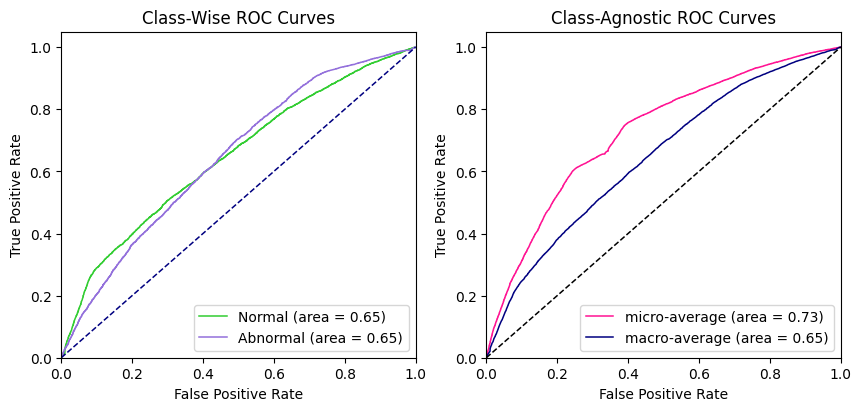

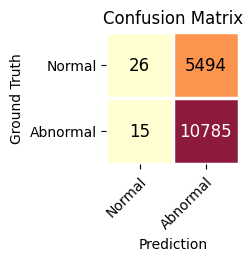

In [7]:
wandb.agent(sweep_id, function=train_sweep, count=count)